✅ Saved timing summary to experiments/features_timings_summary.csv

📊 Summary Table (features):
                   count    mean        std     min      25%     50%      75%  \
type                                                                            
author              10.0  1532.5  41.761891  1506.0  1512.50  1520.0  1526.25   
badge               10.0  1424.9  28.258529  1393.0  1408.25  1413.0  1434.50   
pseudo msg          10.0  1735.8  25.602951  1709.0  1719.00  1723.5  1750.25   
pseudo vote         10.0  1497.1  24.259935  1473.0  1476.50  1491.0  1512.50   
rate-limit pseudo   10.0  1772.2  16.130027  1752.0  1757.00  1770.0  1787.25   

                      max  
type                       
author             1648.0  
badge              1479.0  
pseudo msg         1785.0  
pseudo vote        1546.0  
rate-limit pseudo  1795.0  


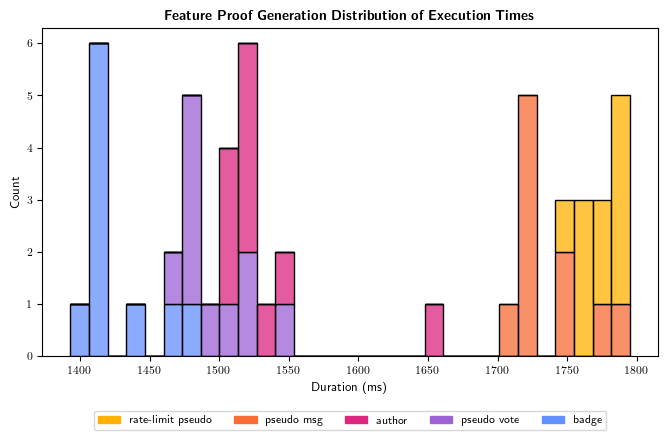

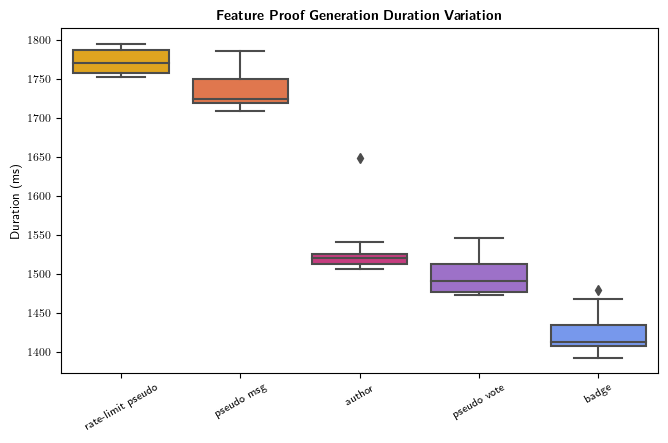

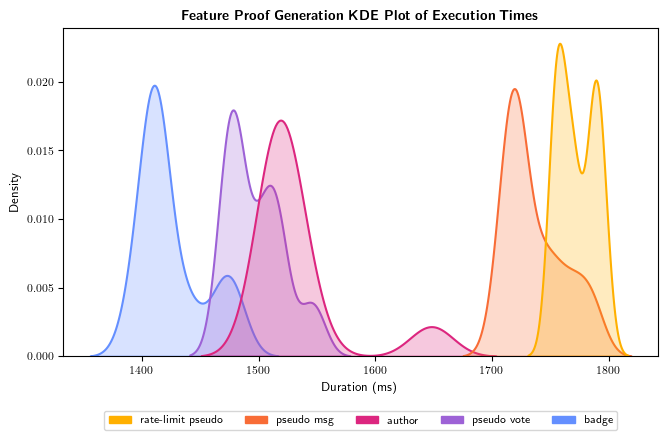

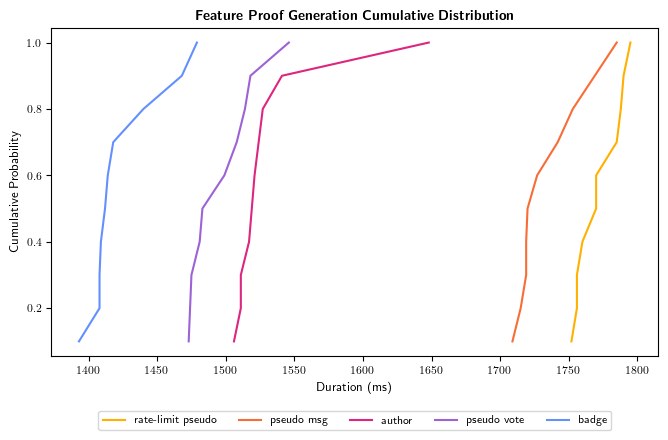

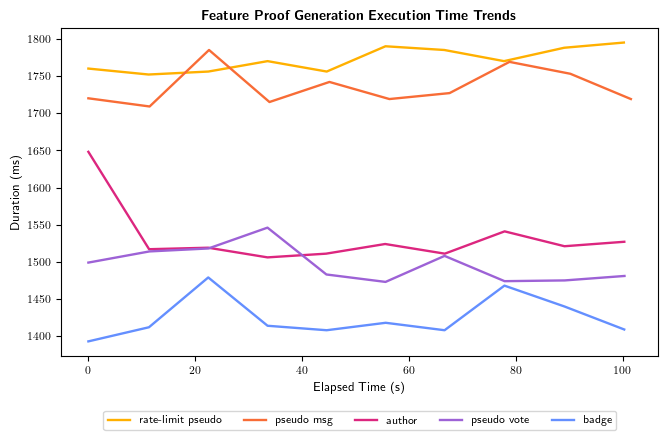

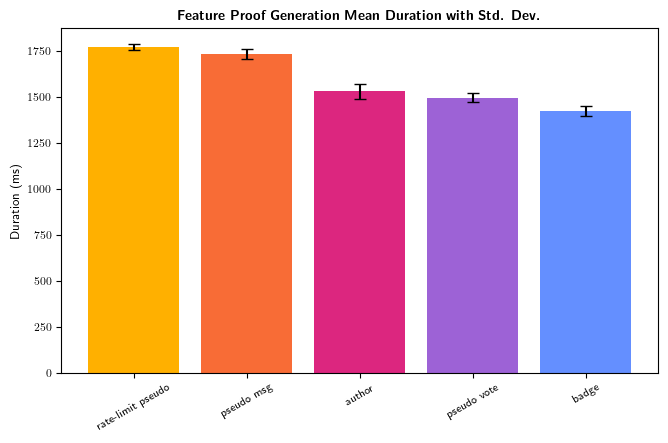


📉 Outliers in features (> 2 std dev):

Outliers in author:
         start_ms  duration_ms
20  1748649022782         1648

Outliers in pseudo vote:
         start_ms  duration_ms
33  1748649053769         1546
✅ Saved timing summary to experiments/latency_features_timings_summary.csv

📊 Summary Table (latency_features):
                   count   mean         std    min     25%    50%     75%  \
type                                                                        
author              10.0  193.3   13.736003  178.0  184.25  187.5  202.25   
badge               10.0  188.0   12.832251  162.0  180.75  192.0  194.75   
pseudo msg          10.0  302.6  108.890567  245.0  264.25  271.5  279.25   
pseudo vote         10.0  198.7   13.524053  179.0  189.25  199.0  202.50   
rate-limit pseudo   10.0  266.0   17.549929  237.0  254.00  268.5  272.75   

                     max  
type                      
author             222.0  
badge              205.0  
pseudo msg         611.0  
pse

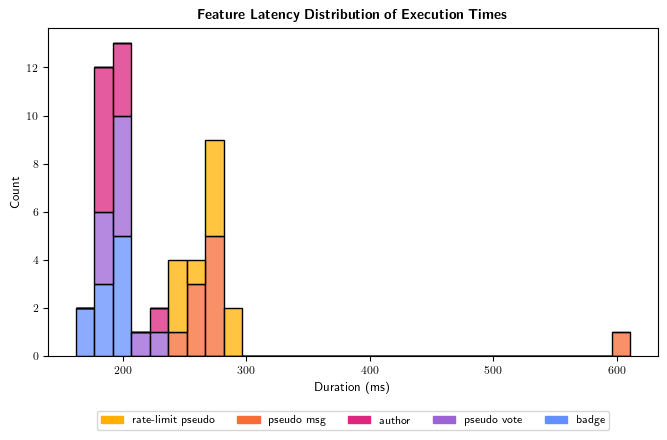

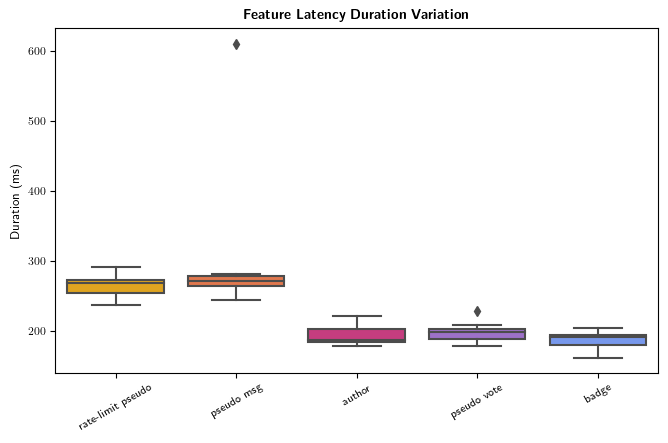

/var/folders/bv/5_26br113jl8hr4hbjx83zmr0000gn/T/ipykernel_78519/3673254280.py:160: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.kdeplot(


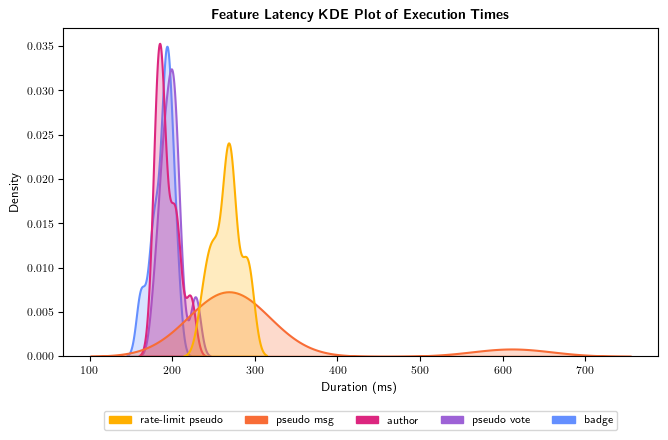

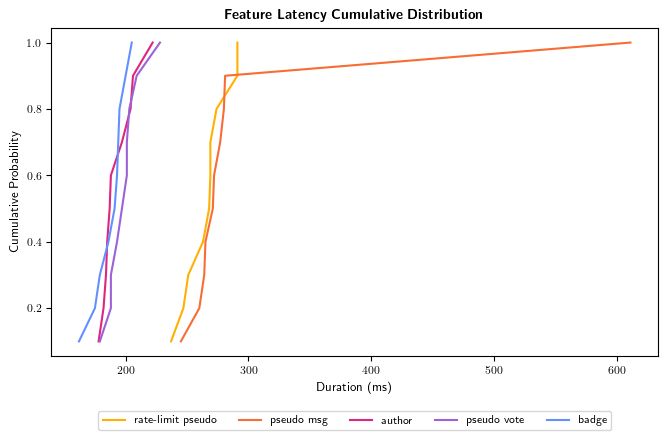

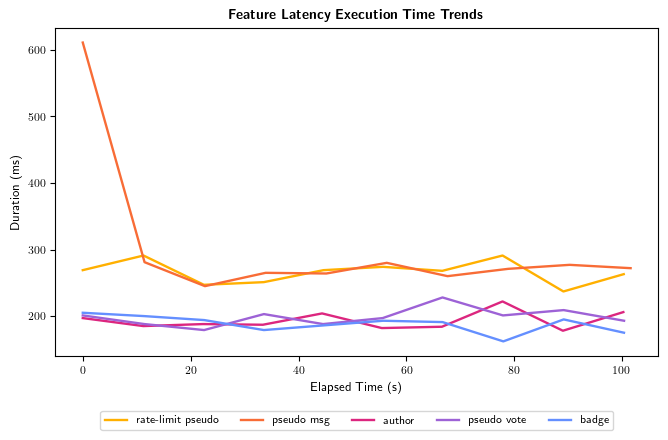

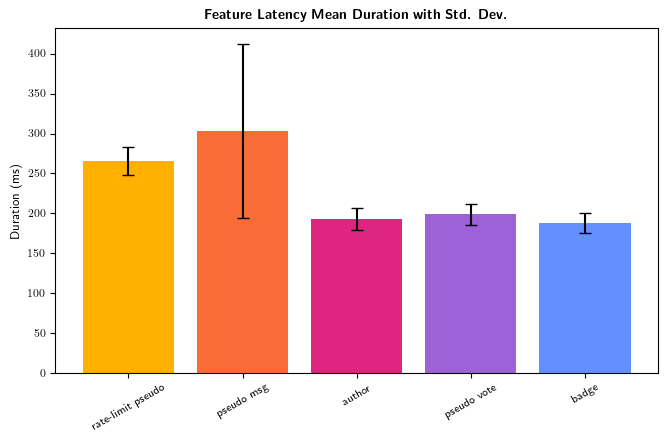


📉 Outliers in latency_features (> 2 std dev):

Outliers in pseudo msg:
         start_ms  duration_ms
10  1748648903041          611

Outliers in author:
         start_ms  duration_ms
27  1748649102252          222

Outliers in pseudo vote:
         start_ms  duration_ms
36  1748649088427          228
✅ Saved timing summary to experiments/verify_features_timings_summary.csv

📊 Summary Table (verify_features):
                   count   mean       std    min     25%    50%     75%    max
type                                                                          
author              10.0   72.5  6.150881   64.0   67.75   74.0   76.00   83.0
badge               10.0   67.8  7.814516   54.0   66.50   70.0   73.75   75.0
pseudo msg          10.0  135.6  6.380526  126.0  130.00  137.0  140.00  144.0
pseudo vote         10.0   72.3  7.972871   60.0   66.75   74.5   78.50   82.0
rate-limit pseudo   10.0  134.4  5.274677  123.0  132.00  136.0  137.75  140.0


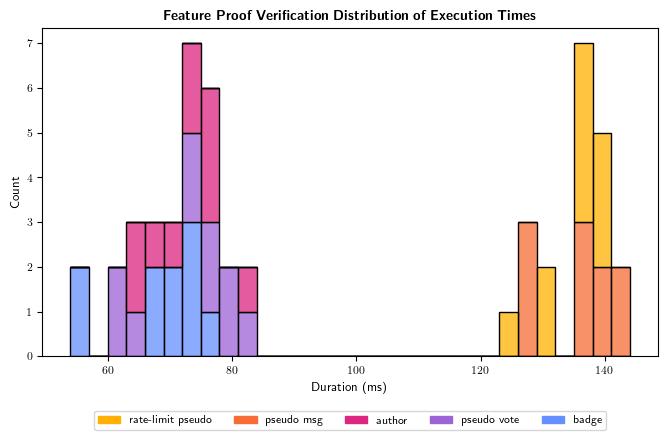

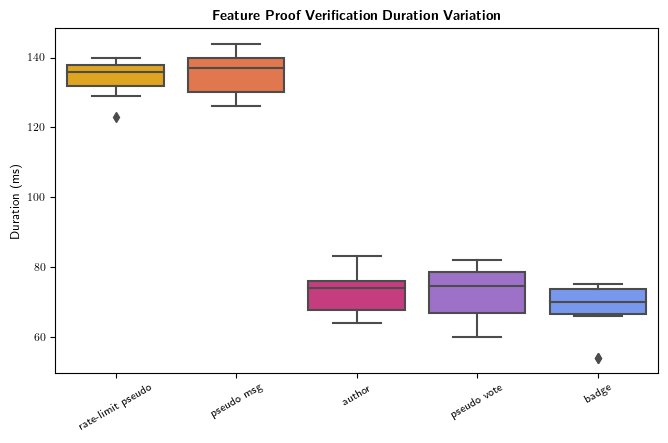

/var/folders/bv/5_26br113jl8hr4hbjx83zmr0000gn/T/ipykernel_78519/3673254280.py:160: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.kdeplot(


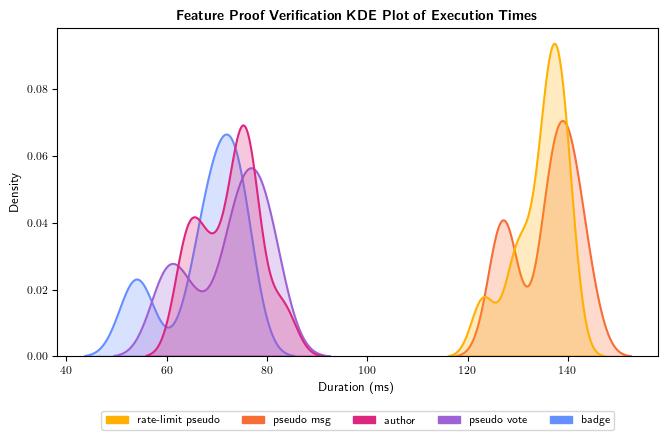

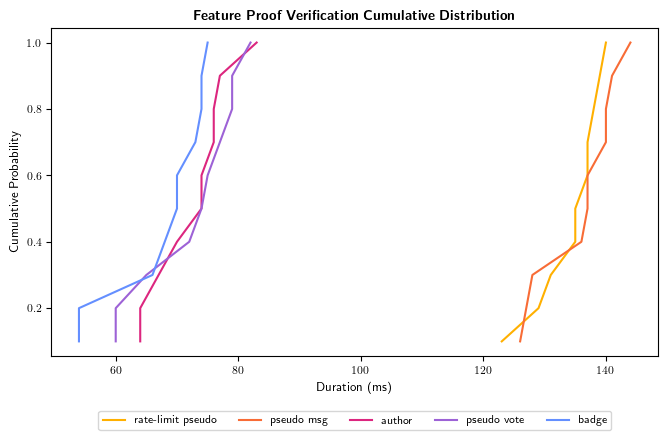

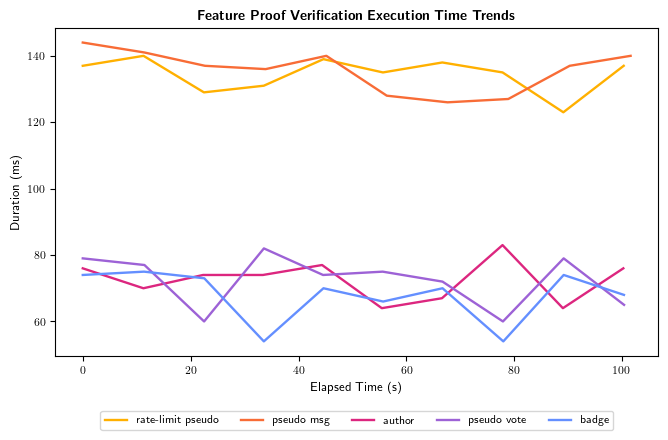

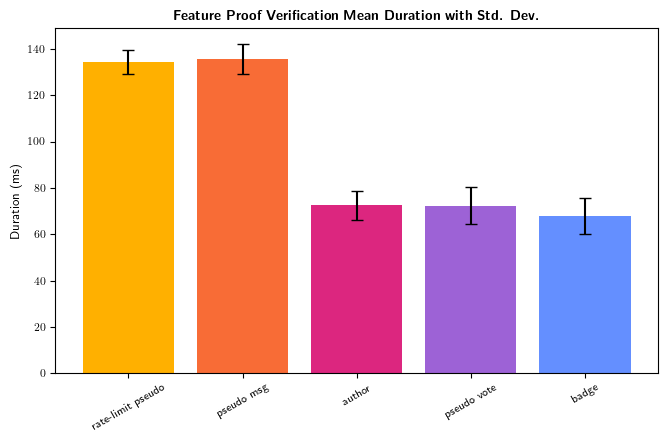


📉 Outliers in verify_features (> 2 std dev):
✅ Saved timing summary to experiments/rep_timings_summary.csv

📊 Summary Table (rep):
      count   mean        std   min    25%    50%    75%    max
type                                                           
rep    10.0  105.2  31.516486  46.0  86.75  107.0  121.0  154.0


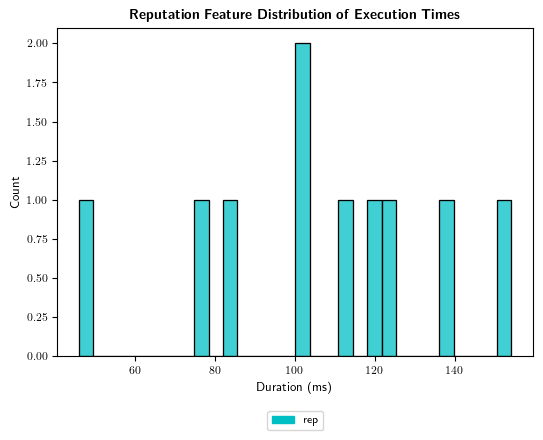

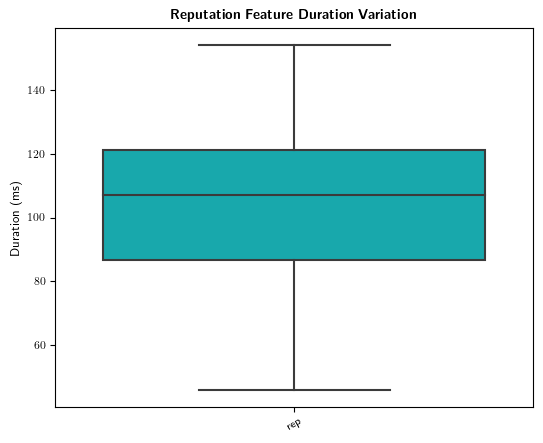

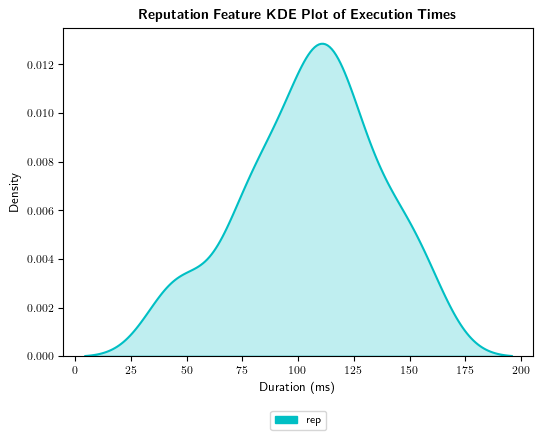

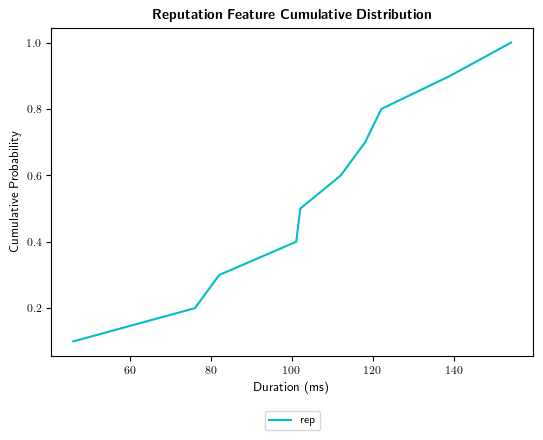

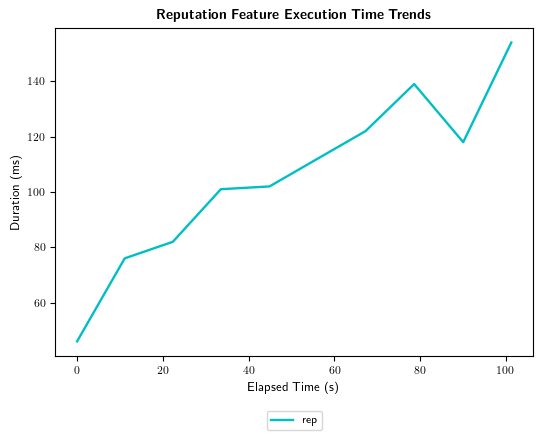

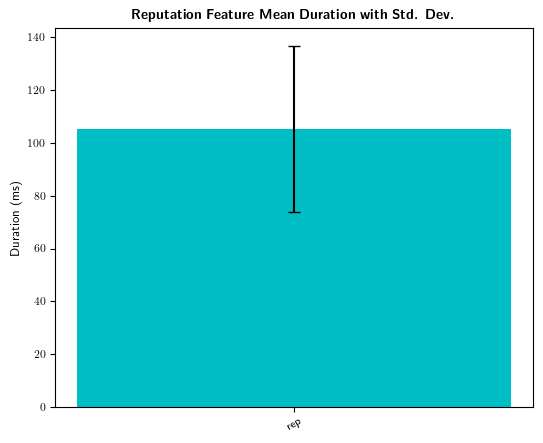


📉 Outliers in rep (> 2 std dev):
✅ Saved timing summary to experiments/call_cb_timings_summary.csv

📊 Summary Table (call_cb):
      count  mean       std   min    25%   50%   75%   max
type                                                      
rep    10.0  28.6  7.058486  14.0  30.25  31.5  32.0  35.0


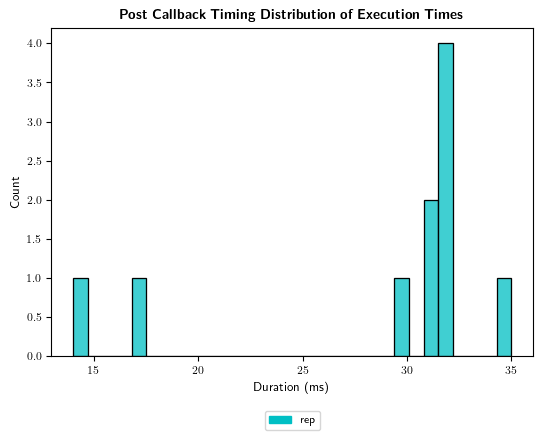

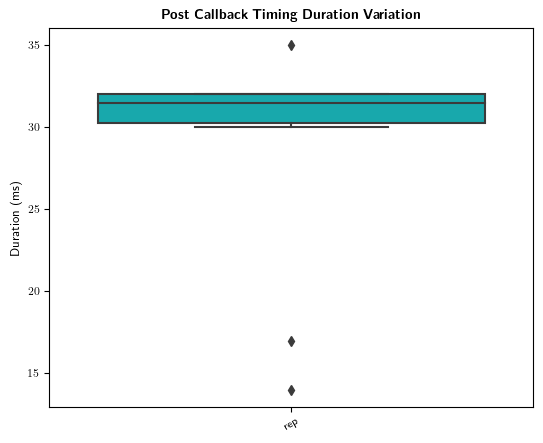

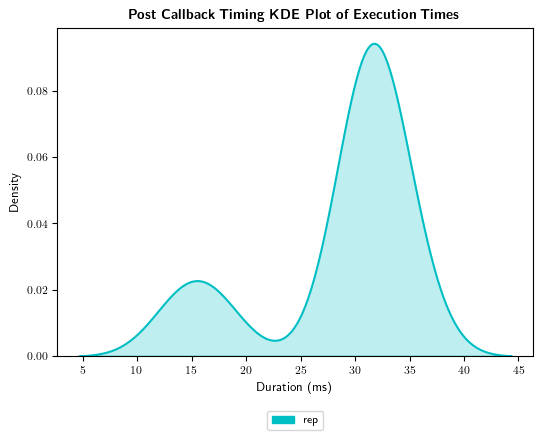

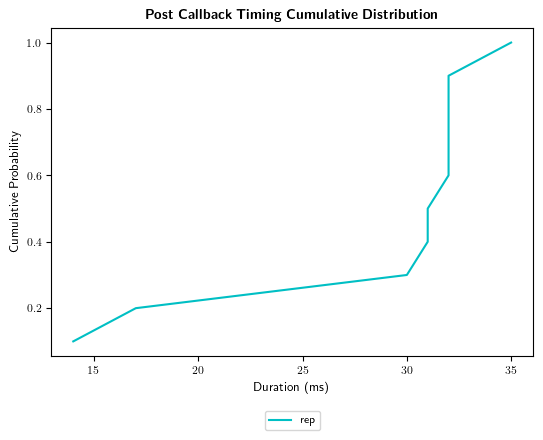

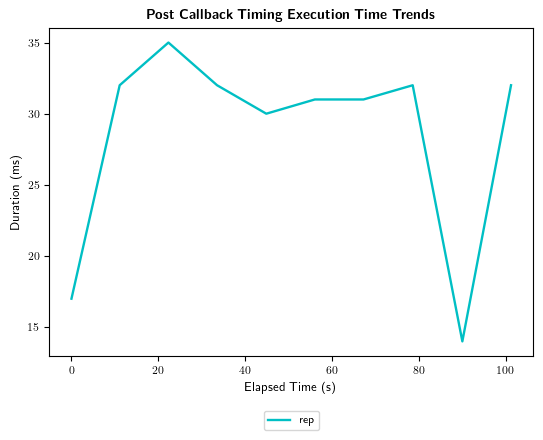

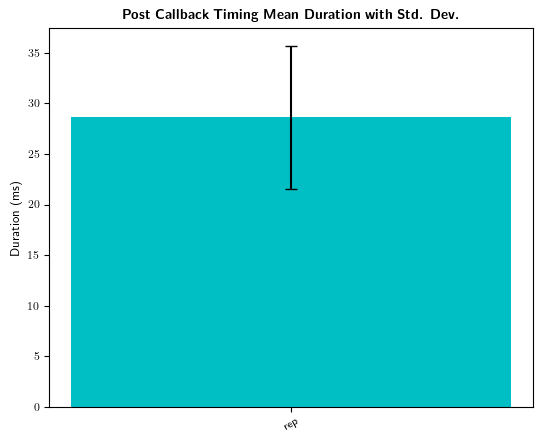


📉 Outliers in call_cb (> 2 std dev):
✅ Saved timing summary to experiments/epoch_timings_summary.csv

📊 Summary Table (epoch):
      count  mean       std   min    25%   50%   75%   max
type                                                      
rep    10.0  28.6  7.058486  14.0  30.25  31.5  32.0  35.0


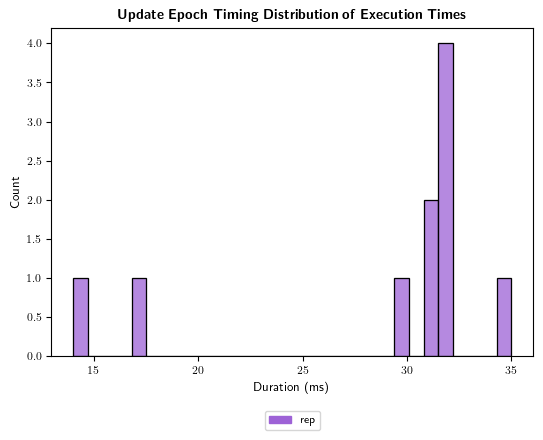

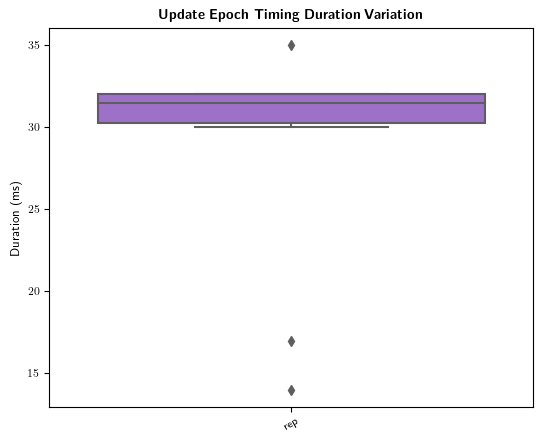

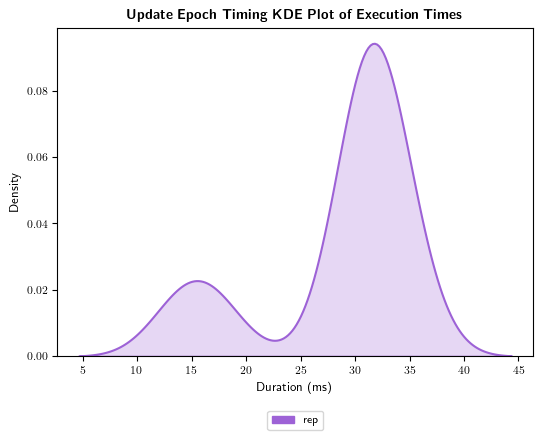

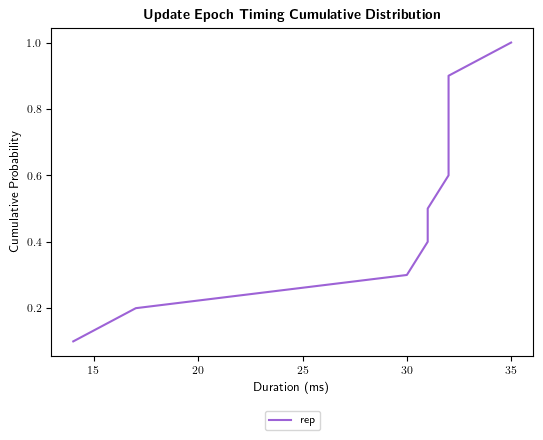

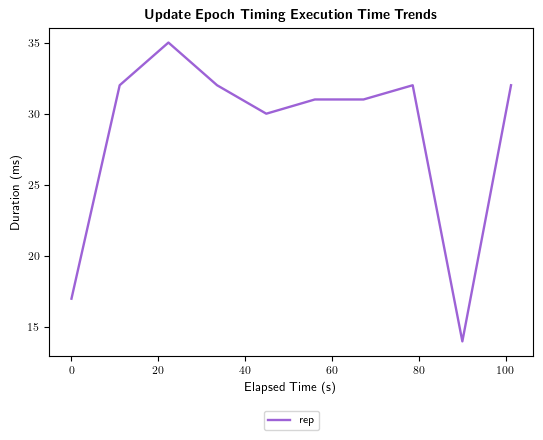

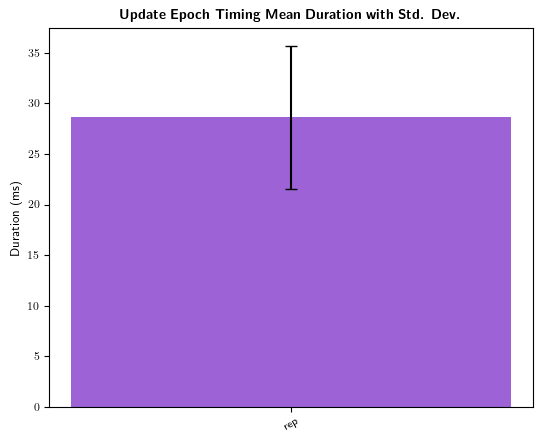


📉 Outliers in epoch (> 2 std dev):


In [16]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
import matplotlib.patches as mpatches

# --------------------------------------------
# Step 1: Load timing data from .jsonl files
# --------------------------------------------

def load_jsonl_timings(label, path, file):
    file_path = os.path.join(path, file)
    rows = []
    if not os.path.exists(file_path):
        print(f"No file at: {file_path}")
        return rows

    with open(file_path) as f:
        for line in f:
            try:
                data = json.loads(line)
                rows.append({
                    "type": label,
                    "start_ms": int(data["start_ms"]),
                    "duration_ms": int(data["duration_ms"])
                })
            except Exception as e:
                print(f"Failed to parse line: {e}")
    return rows

# Matplotlib vector-friendly and font embedding settings
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "figure.titlesize": 10,
    "pgf.rcfonts": False
})

# Color Accessibility Pallette Tool
custom_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']
#custom_colors = ['#FFEB2E', '#FFB521', '#FF7028', '#E03A2F', '#DC267F', '#9D62D6', '#648FFF', '#00BFC4', '#4FE192', '#9EF572']

def autosize(n_labels):
    width = max(5.5, 3 + 0.75 * n_labels)
    height = 4.5
    return (width, height)

def save_plot(fig, path_without_ext):
    fig.savefig(f"{path_without_ext}.pdf", bbox_inches="tight")
    fig.savefig(f"{path_without_ext}.pgf", bbox_inches="tight")

def run_analysis(config, 
                 output_prefix, 
                 data_file, 
                 custom_title_prefix="", 
                 custom_colors= ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']
                ):
    # rows = []
    # for label, path in label_to_path_dict.items():
    #     rows += load_jsonl_timings(label, path, data_file)

    rows = []
    for label, path in config.items():
        rows += load_jsonl_timings(label, path, data_file)

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ No timing data available. Skipping analysis.")
        return

    base_dir = f"experiments/{output_prefix}"
    os.makedirs(f"{base_dir}_plots", exist_ok=True)

    df.to_csv(f"{base_dir}_timings_summary.csv", index=False)
    print(f"✅ Saved timing summary to {base_dir}_timings_summary.csv")

    df["start_time"] = pd.to_datetime(df["start_ms"], unit="ms")
    summary_table = df.groupby("type")["duration_ms"].describe()
    print(f"\n📊 Summary Table ({output_prefix}):")
    print(summary_table)
    summary_table.to_csv(f"{base_dir}_timings_stats.csv")

    n_labels = df["type"].nunique()
    size = autosize(n_labels)

    # # Histogram
    fig = plt.figure(figsize=size)
    # sns.histplot(
    #     data=df,
    #     x="duration_ms",
    #     hue="type",
    #     element="step",
    #     bins=30,
    #     common_norm=False,
    #     stat="count",
    #     palette=custom_colors[:n_labels],
    #     legend=False
    # )
    # num_bins = n_labels * 10;
    sns.histplot(
        data=df,
        x="duration_ms",
        hue="type",
        multiple="stack",

        bins=30,
        common_norm=False,
        stat="count",
        palette=custom_colors[:n_labels],
        legend=False
    )

    handles = [
        mpatches.Patch(color=custom_colors[i], label=label)
        for i, label in enumerate(df["type"].unique())
    ]
    plt.title(rf"\textbf{{{custom_title_prefix} Distribution of Execution Times}}")
    plt.xlabel("Duration (ms)")
    plt.ylabel("Count")
    plt.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=len(handles))
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/histogram")
    plt.show()
    plt.close()

    # Boxplot
    fig = plt.figure(figsize=size)
    sns.boxplot(data=df, x="type", y="duration_ms", palette=custom_colors)
    plt.title(rf"\textbf{{{custom_title_prefix} Duration Variation}}")
    plt.ylabel("Duration (ms)")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/boxplot")
    plt.show()
    plt.close()

    # KDF Plot
    min_val = df["duration_ms"].min()
    max_val = df["duration_ms"].max()
    if min_val == max_val:
        print("All values are identical; KDE plot will not work.")
    else:
        plt.figure(figsize=size)  # only create once!
        sns.kdeplot(
            data=df,
            x="duration_ms",
            hue="type",
            fill=True,
            common_norm=False,
            linewidth=1.5,
            bw_adjust=0.7,
            #clip=(min_val, max_val),
            palette=custom_colors,
            legend=False
        )

        handles = [
            mpatches.Patch(color=custom_colors[i], label=label)
            for i, label in enumerate(df["type"].unique())
        ]
    
        plt.xlabel("Duration (ms)")
        plt.ylabel("Density")
        plt.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=len(handles))
        plt.title(rf"\textbf{{{custom_title_prefix} KDE Plot of Execution Times}}")
        #plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
    
        fig = plt.gcf()  # get the current figure with the plot
        save_plot(fig, f"{base_dir}_plots/kde")
        plt.show()
        plt.close()



    # CDF
    fig = plt.figure(figsize=size) #plt.figure(figsize=(4.5, 3.5))
    for i, label in enumerate(df['type'].unique()):
        subset = df[df['type'] == label]['duration_ms'].sort_values()
        cum_prob = range(1, len(subset) + 1)
        plt.plot(subset, [x / len(subset) for x in cum_prob], label=label, color=custom_colors[i % len(custom_colors)])
    plt.title(rf"\textbf{{{custom_title_prefix} Cumulative Distribution}}")
    plt.xlabel("Duration (ms)")
    plt.ylabel("Cumulative Probability")
    plt.legend(title=None, loc='upper center',  bbox_to_anchor=(0.5, -0.15), ncol=n_labels)
    #plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/cdf")
    plt.show()
    plt.close()

    # Trend
    df["elapsed_sec"] = df.groupby("type")["start_time"].transform(lambda x: (x - x.min()).dt.total_seconds())
    #df["elapsed_sec"] = (df["start_time"] - df["start_time"].min()).dt.total_seconds()

    fig = plt.figure(figsize=size)
    for i, label in enumerate(df["type"].unique()):
        sub_df = df[df["type"] == label]
        plt.plot(
            sub_df["elapsed_sec"],
            sub_df["duration_ms"],
            label=label,
            linewidth=1.7,
            color=custom_colors[i % len(custom_colors)]
        )
    plt.legend(title=None, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=n_labels)
    plt.title(rf"\textbf{{{custom_title_prefix} Execution Time Trends}}")
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Duration (ms)")
    #plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/trend")
    plt.show()
    plt.close()

    # Bar chart with error bars
    type_order = df["type"].drop_duplicates().tolist()
    means = df.groupby("type")["duration_ms"].mean().reindex(type_order)
    stds = df.groupby("type")["duration_ms"].std().reindex(type_order)
    fig = plt.figure(figsize=size)
    plt.bar(type_order, means.values, yerr=stds.values, capsize=4, color=custom_colors[:len(type_order)])
    plt.title(rf"\textbf{{{custom_title_prefix} Mean Duration with Std. Dev.}}")
    plt.ylabel("Duration (ms)")
    plt.xlabel("")
    plt.xticks(rotation=30)
    plt.tight_layout()
    save_plot(fig, f"{base_dir}_plots/means_with_error")
    plt.show()
    plt.close()

    # Outliers
    print(f"\n📉 Outliers in {output_prefix} (> 2 std dev):")
    for label in df['type'].unique():
        subset = df[df['type'] == label]
        mu = subset["duration_ms"].mean()
        sigma = subset["duration_ms"].std()
        outliers = subset[subset["duration_ms"] > mu + 2 * sigma]
        if not outliers.empty:
            print(f"\nOutliers in {label}:")
            print(outliers[["start_ms", "duration_ms"]])

def plot_core_subplots(core_paths, data_file="timings.jsonl", output_prefix="core_subplots"):
    # Load data
    rows = []
    for label, path in core_paths.items():
        rows += load_jsonl_timings(label, path, data_file)
    df = pd.DataFrame(rows)

    if df.empty:
        print("⚠️ No data for core subplots.")
        return

    # Setup figure
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))  # 3 side-by-side plots
    plot_types = ["proof gen", "proof verify", "latency"]
    colors = custom_colors[:3]

    for i, label in enumerate(plot_types):
        ax = axes[i]
        subset = df[df["type"] == label]
        # sns.histplot(
        #     data=subset,
        #     x="duration_ms",
        #     bins=20,
        #     stat="count",
        #     ax=ax,
        #     color=colors[i]
        # )
        sns.histplot(
            data=subset,
            x="duration_ms",
            element="step",
            bins=30,
            common_norm=False,
            stat="count",
            ax=ax,
            color=colors[i]
        )
        ax.set_title(rf"\textbf{{{label}}}")
        ax.set_xlabel("Duration (ms)")
        if i == 0:
            ax.set_ylabel("Count")
        else:
            ax.set_ylabel("")

    plt.tight_layout()
    out_path = f"experiments/{output_prefix}"
    os.makedirs("experiments", exist_ok=True)
    fig.savefig(f"{out_path}.pdf", bbox_inches="tight")
    fig.savefig(f"{out_path}.pgf", bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"✅ Saved subplot plots to {out_path}.pdf and .pgf")

def plot_core_line_subplots(core_paths, data_file="timings.jsonl", output_prefix="core"):
    base_dir = f"experiments/{output_prefix}"
    # Load data
    rows = []
    for label, path in core_paths.items():
        rows += load_jsonl_timings(label, path, data_file)
    df = pd.DataFrame(rows)

    if df.empty:
        print("⚠️ No data for core line subplots.")
        return

    # Time conversion
    df["start_time"] = pd.to_datetime(df["start_ms"], unit="ms")
    df["elapsed_sec"] = df.groupby("type")["start_time"].transform(lambda x: (x - x.min()).dt.total_seconds())

    # Setup vertical subplots
    fig, axes = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
    fig.subplots_adjust(hspace=0.3)
    plot_types = ["proof gen", "latency", "proof verify"]
    colors = custom_colors[:3]

    for i, label in enumerate(plot_types):
        ax = axes[i]
        sub_df = df[df["type"] == label]
        ax.plot(
            sub_df["elapsed_sec"],
            sub_df["duration_ms"],
            label=label,
            linewidth=1.2,
            color=colors[i]
        )
        cap_label = label.title()
        ax.set_title(rf"\textbf{{Anonymous Message {cap_label}}}")
        # if i == len(plot_types) - 1:
        #     ax.set_xlabel("Elapsed Time (s)")
        ax.grid(True, linestyle="--", alpha=0.5)

    # Common y-label
    fig.text(0.04, 0.5, 'Duration (ms)', va='center', rotation='vertical', fontsize=12)
    fig.supxlabel("Elapsed Time (s)", y=0.08, va='center', fontsize=12)

    fig.suptitle(rf"\textbf{{Anonymous Message Proof Generation, Proof Verification, and Latency }}", x=0.56)

    # Collect all handles/labels across subplots
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    # Optional: deduplicate
    seen = set()
    unique = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
    handles, labels = zip(*unique)
    
    # Shared legend at bottom
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.003))

    # Save plots
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.98])
    out_path = f"experiments/{output_prefix}"
    os.makedirs("experiments", exist_ok=True)
    save_plot(fig, f"{base_dir}_plots/subplot")
    plt.show()
    plt.close()
    print(f"✅ Saved stacked line subplots to {out_path}.pdf and .pgf")


file_configs = [
    # {
    #     "name": "core",
    #     "paths": {
    #         "proof gen": "json_files/1",
    #         "proof verify": "json_files/2",
    #         "latency": "json_files/3"
    #     },
    #     "colors": ['#ffb000', '#f86c36', '#dc267f'],
    #     "data_file": "timings.jsonl",
    #     "title_prefix": "Anonymous Message",
    #     "plot_type": "line"
    # },
    {
        "name": "features",
        "paths": {
            "rate-limit pseudo": "json_files/rate_pseudo",
            "pseudo msg": "json_files/pseudo_msg",
            "author": "json_files/author",
            "pseudo vote": "json_files/pseudo_vote",
            "badge": "json_files/badge"
        },
        "colors": ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff'],
        "data_file": "timings.jsonl",
        "title_prefix": "Feature Proof Generation"
    },
    {
        "name": "latency_features",
        "paths": {
            "rate-limit pseudo": "json_files/rate_pseudo",
            "pseudo msg": "json_files/pseudo_msg",
            "author": "json_files/author",
            "pseudo vote": "json_files/pseudo_vote",
            "badge": "json_files/badge"
        },
        "colors": ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200'],
        "data_file": "features_timings.jsonl",
        "title_prefix": "Feature Latency"
    },
    {
        "name": "verify_features",
        "paths": {
            "rate-limit pseudo": "json_files/rate_pseudo",
            "pseudo msg": "json_files/pseudo_msg",
            "author": "json_files/author",
            "pseudo vote": "json_files/pseudo_vote",
            "badge": "json_files/badge"
        },
        "colors": ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200'],
        "data_file": "verify_timings.jsonl",
        "title_prefix": "Feature Proof Verification"
    },
    {
        "name": "rep",
        "paths": {
            "rep": "json_files/rep"
        },
        "colors": ['#00bfc4'],
        "data_file": "features_timings.jsonl",
        "title_prefix": "Reputation Feature"
    },
    {
        "name": "call_cb",
        "paths": {
            "rep": "json_files/rep"
        },
        "colors": ['#00bfc4'],
        "data_file": "call_timings.jsonl",
        "title_prefix": "Post Callback Timing"
    },
    {
        "name": "epoch",
        "paths": {
            "rep": "json_files/rep"
        },
        "colors": ['#9d62d6'],
        "data_file": "call_timings.jsonl",
        "title_prefix": "Update Epoch Timing"
    }
]

for config in file_configs:
    run_analysis(
        config["paths"],
        output_prefix=config["name"],
        data_file=config["data_file"],
        custom_title_prefix=config["title_prefix"],
        custom_colors=config["colors"]
    )

    # Optional: only run line plot for specific configs
    if config.get("plot_type") == "line":
        plot_core_line_subplots(config["paths"])


# Core
# core_paths = {
#     "proof gen": "json_files/1",
#     "proof verify": "json_files/2",
#     "latency": "json_files/3"
# }
# core_colors = ['#ffb000', '#f86c36', '#dc267f']
# # core_colors = [
# #     '#ff6db6',  # vivid pink (lighter and cooler than #dc267f)
# #     '#785ef0',  # modern indigo (from Paul Tol’s colorblind-safe palette)
# #     '#00b06e'   # deep turquoise green
# # ]
# #core_colors =  ['#FFEB2E', '#FFB521', '#FF7028']

# run_analysis(core_paths, output_prefix="core", data_file="timings.jsonl", custom_title_prefix="Anonymous Message", custom_colors = core_colors)
# #plot_core_subplots(core_paths)
# plot_core_line_subplots(core_paths)

# Proof Gen
# Features
# feature_paths = {
#     "rate-limit pseudo": "json_files/rate_pseudo",
#     "pseudo msg": "json_files/pseudo_msg",
#     "author": "json_files/author",
#     "pseudo vote": "json_files/pseudo_vote",
#     "badge": "json_files/badge"
# }
# feature_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff']
# #feature_colors = ['#E03A2F', '#DC267F', '#9D62D6', '#648FFF', '#00BFC4']
# run_analysis(feature_paths, output_prefix="features", data_file="timings.jsonl", custom_title_prefix="Feature Proof Generation", custom_colors=feature_colors)

# # Latency Features
# latency_feature_paths = {
#     "rate-limit pseudo": "json_files/rate_pseudo",
#     "pseudo msg": "json_files/pseudo_msg",
#     "author": "json_files/author",
#     "pseudo vote": "json_files/pseudo_vote",
#     "badge": "json_files/badge"
    
   
#     #"ban": "json_files/ban", 
#     #"rep": "json_files/rep"
# }
# latency_feature_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']
# #latency_feature_colors = ['#E03A2F', '#DC267F', '#9D62D6', '#648FFF', '#00BFC4', '#4FE192', '#9EF572']
# run_analysis(latency_feature_paths, output_prefix="latency_features", data_file="features_timings.jsonl", custom_title_prefix="Feature Latency", custom_colors=latency_feature_colors)

# # Ban and Rep
# ban_rep_paths = {
#     "ban": "json_files/ban", 
#     "rep": "json_files/rep"
# }
# ban_rep_colors = ['#00bfc4', '#90d200']
# #ban_rep_colors = ['#4FE192', '#9EF572']
# run_analysis(ban_rep_paths, output_prefix="ban_rep", data_file="features_timings.jsonl", custom_title_prefix="Ban and Reputation", custom_colors=ban_rep_colors)


# verify_feature_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']
# # Latency Features
# verify_feature_paths = {
#     "rate-limit pseudo": "json_files/rate_pseudo",
#     "pseudo msg": "json_files/pseudo_msg",
#     "author": "json_files/author",
#     "pseudo vote": "json_files/pseudo_vote",
#     "badge": "json_files/badge"
# }
# verify_feature_colors = ['#ffb000', '#f86c36', '#dc267f', '#9d62d6', '#648fff', '#00bfc4', '#90d200']
# #latency_feature_colors = ['#E03A2F', '#DC267F', '#9D62D6', '#648FFF', '#00BFC4', '#4FE192', '#9EF572']
# run_analysis(verify_feature_paths, output_prefix="verify_features", data_file="verify_timings.jsonl", custom_title_prefix="Feature Proof Verification", custom_colors=verify_feature_colors)




